# Train a VAE on Cell Painting LINCS Data

In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
sys.path.insert(0, "../../scripts")
from utils import load_data


from pycytominer.cyto_utils import infer_cp_features


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.decomposition import PCA
from tensorflow import keras

from vae import VAE

from tensorflow.keras.models import Model, Sequential
import seaborn
import random as python_random
import tensorflow as tf


In [2]:
# %load_ext nb_black

In [3]:
# np.random.seed(123)
# python_random.seed(123)
# tf.random.set_random_seed(1234)

In [4]:
data_splits = ["train", "test", "valid","complete"]
data_dict = load_data(data_splits)

/home/ubuntu/miniconda3/envs/cell-painting-vae/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [5]:
# Prepare data for training
meta_features = infer_cp_features(data_dict["train"], metadata=True)
cp_features = infer_cp_features(data_dict["train"])

train_features_df = data_dict["train"].reindex(cp_features, axis="columns")
train_meta_df = data_dict["train"].reindex(meta_features, axis="columns")

test_features_df = data_dict["test"].reindex(cp_features, axis="columns")
test_meta_df = data_dict["test"].reindex(meta_features, axis="columns")

valid_features_df = data_dict["valid"].reindex(cp_features, axis="columns")
Valid_meta_df = data_dict["valid"].reindex(meta_features, axis="columns")


complete_features_df = data_dict["complete"].reindex(cp_features, axis="columns")
complete_meta_df = data_dict["complete"].reindex(meta_features, axis="columns")


In [6]:
print(train_features_df.shape)
train_features_df.head(3)

(40242, 685)


,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_MedianRadius,Cells_AreaShape_Orientation,Cells_AreaShape_Solidity,Cells_AreaShape_Zernike_0_0,Cells_AreaShape_Zernike_1_1,Cells_AreaShape_Zernike_2_0,...,Nuclei_Texture_SumEntropy_DNA_5_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumEntropy_RNA_20_0,Nuclei_Texture_SumEntropy_RNA_5_0,Nuclei_Texture_SumVariance_DNA_20_0,Nuclei_Texture_SumVariance_RNA_20_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_ER_20_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_20_0
0,0.19790,0.69605,0.40400,0.30834,0.19317,0.71895,0.38837,0.38668,0.62494,0.87362,...,0.61045,0.41907,0.64945,0.65199,0.22660,0.32108,0.29776,0.26173,0.34524,0.32151
1,0.18605,0.68873,0.41051,0.31982,0.19885,0.72510,0.39552,0.38362,0.65094,0.89679,...,0.61393,0.38269,0.63814,0.68204,0.23700,0.32808,0.27981,0.26893,0.34938,0.33179
2,0.19083,0.66276,0.38585,0.31437,0.20415,0.71380,0.38701,0.36699,0.60932,0.88492,...,0.60850,0.41850,0.63529,0.65208,0.22852,0.32710,0.29371,0.27159,0.33871,0.31965


In [7]:
print(test_features_df.shape)
test_features_df.head(3)

(5030, 685)


,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_MedianRadius,Cells_AreaShape_Orientation,Cells_AreaShape_Solidity,Cells_AreaShape_Zernike_0_0,Cells_AreaShape_Zernike_1_1,Cells_AreaShape_Zernike_2_0,...,Nuclei_Texture_SumEntropy_DNA_5_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumEntropy_RNA_20_0,Nuclei_Texture_SumEntropy_RNA_5_0,Nuclei_Texture_SumVariance_DNA_20_0,Nuclei_Texture_SumVariance_RNA_20_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_ER_20_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_20_0
0,0.19050,0.68937,0.39383,0.33072,0.20185,0.72292,0.38085,0.37504,0.61905,0.88361,...,0.60356,0.39345,0.63470,0.63406,0.23588,0.36061,0.30092,0.23638,0.36015,0.32779
1,0.18661,0.67731,0.39621,0.32318,0.20716,0.70964,0.39401,0.37779,0.60275,0.88912,...,0.60936,0.40380,0.64406,0.64859,0.22752,0.29811,0.29430,0.25475,0.34154,0.32013
2,0.18626,0.67036,0.41101,0.31863,0.20182,0.71139,0.40302,0.38979,0.59188,0.86857,...,0.61009,0.40904,0.64250,0.63285,0.23931,0.33179,0.28571,0.24980,0.34516,0.32968


In [8]:
print(complete_features_df.shape)
complete_features_df.head(3)

(50303, 685)


,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_MedianRadius,Cells_AreaShape_Orientation,Cells_AreaShape_Solidity,Cells_AreaShape_Zernike_0_0,Cells_AreaShape_Zernike_1_1,Cells_AreaShape_Zernike_2_0,...,Nuclei_Texture_SumEntropy_DNA_5_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumEntropy_RNA_20_0,Nuclei_Texture_SumEntropy_RNA_5_0,Nuclei_Texture_SumVariance_DNA_20_0,Nuclei_Texture_SumVariance_RNA_20_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_ER_20_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_20_0
0,0.19575,0.67566,0.40288,0.32633,0.20267,0.71477,0.39122,0.38048,0.61184,0.88375,...,0.60865,0.38869,0.65364,0.65716,0.24912,0.33129,0.28864,0.27106,0.35254,0.32675
1,0.18472,0.66556,0.39721,0.30968,0.20009,0.71345,0.39953,0.37314,0.61074,0.87695,...,0.60682,0.39779,0.64013,0.63120,0.24380,0.30471,0.28554,0.27852,0.35157,0.31637
2,0.18254,0.69650,0.39596,0.33502,0.20420,0.72770,0.39590,0.37023,0.60264,0.88038,...,0.60665,0.39705,0.66616,0.62889,0.25125,0.33549,0.29656,0.25706,0.33868,0.31901


In [9]:
# VAE of one layer
# encoder_architecture = [500,250,100]
# decoder_architecture = [100,250,500]
encoder_architecture = [250]
decoder_architecture = [250]


# encoder_architecture = [500,500,250,100]
# decoder_architecture = [100,250,500,500]



In [145]:

# cp_vae = VAE(
#     input_dim=train_features_df.shape[1],
#     latent_dim=90,
#     batch_size=32,
#     encoder_batch_norm=True,
#     epochs=58,
#     learning_rate=0.0001,
#     encoder_architecture=encoder_architecture,
#     decoder_architecture=decoder_architecture,
#     beta=0,
#     lam=100000,
#     verbose=True,
# )
cp_vae = VAE(
    input_dim=train_features_df.shape[1],
    latent_dim=90,
    batch_size=32,
    encoder_batch_norm=True,
    epochs=50,
    learning_rate=0.0001,
    encoder_architecture=encoder_architecture,
    decoder_architecture=decoder_architecture,
    beta=0,
    lam=10000,
    verbose=True,
)


cp_vae.compile_vae()

In [146]:
cp_vae.train(x_train=train_features_df, x_test=valid_features_df)

Epoch 1/50
1258/1258 [==============================] - 8s 5ms/step - loss: 138.6248 - recon: 55.6475 - kl: 0.0000e+00 - mmd: 18.1926 - val_loss: 34.9447 - val_recon: 11.8683 - val_kl: 0.0000e+00 - val_mmd: 22.6795
Epoch 2/50
1258/1258 [==============================] - 6s 4ms/step - loss: 24.8545 - recon: 7.4328 - kl: 0.0000e+00 - mmd: 15.5843 - val_loss: 26.0595 - val_recon: 5.5033 - val_kl: 0.0000e+00 - val_mmd: 20.8468
Epoch 3/50
1258/1258 [==============================] - 5s 4ms/step - loss: 19.6734 - recon: 4.3616 - kl: 0.0000e+00 - mmd: 14.6320 - val_loss: 27.2320 - val_recon: 3.6532 - val_kl: 0.0000e+00 - val_mmd: 24.1332
Epoch 4/50
1258/1258 [==============================] - 5s 4ms/step - loss: 17.4520 - recon: 2.9827 - kl: 0.0000e+00 - mmd: 14.0357 - val_loss: 26.0054 - val_recon: 2.5513 - val_kl: 0.0000e+00 - val_mmd: 23.6133
Epoch 5/50
1258/1258 [==============================] - 5s 4ms/step - loss: 15.9563 - recon: 2.1199 - kl: 0.0000e+00 - mmd: 13.7332 - val_loss: 26.63

1258/1258 [==============================] - 5s 4ms/step - loss: 11.4573 - recon: 0.5649 - kl: 0.0000e+00 - mmd: 10.8619 - val_loss: 18.0288 - val_recon: 0.5273 - val_kl: 0.0000e+00 - val_mmd: 17.8539
Epoch 40/50
1258/1258 [==============================] - 5s 4ms/step - loss: 11.3448 - recon: 0.5615 - kl: 0.0000e+00 - mmd: 10.8493 - val_loss: 15.6469 - val_recon: 0.5306 - val_kl: 0.0000e+00 - val_mmd: 15.1784
Epoch 41/50
1258/1258 [==============================] - 5s 4ms/step - loss: 11.2557 - recon: 0.5596 - kl: 0.0000e+00 - mmd: 10.7082 - val_loss: 14.9570 - val_recon: 0.5221 - val_kl: 0.0000e+00 - val_mmd: 14.5372
Epoch 42/50
1258/1258 [==============================] - 5s 4ms/step - loss: 11.1669 - recon: 0.5558 - kl: 0.0000e+00 - mmd: 10.6496 - val_loss: 16.3767 - val_recon: 0.5254 - val_kl: 0.0000e+00 - val_mmd: 16.4412
Epoch 43/50
1258/1258 [==============================] - 5s 4ms/step - loss: 11.1230 - recon: 0.5523 - kl: 0.0000e+00 - mmd: 10.6092 - val_loss: 19.3654 - val_r

In [147]:
cp_vae.vae

In [148]:
# Save training performance
history_df = pd.DataFrame(cp_vae.vae.history.history)
history_df

,loss,recon,kl,mmd,val_loss,val_recon,val_kl,val_mmd
0,73.785606,55.647533,0.0,18.192554,34.944691,11.868347,0.0,22.679482
1,23.047516,7.432819,0.0,15.584281,26.059488,5.503315,0.0,20.846792
2,18.926090,4.361557,0.0,14.632034,27.231972,3.653193,0.0,24.133249
3,17.044889,2.982715,0.0,14.035686,26.005426,2.551328,0.0,23.613255
4,15.672250,2.119900,0.0,13.733183,26.637259,1.937015,0.0,25.275005
5,15.007181,1.598745,0.0,13.468155,23.810711,1.435574,0.0,22.517473
6,14.640365,1.279174,0.0,13.460178,25.572422,1.247680,0.0,24.759935
7,14.193045,1.079372,0.0,13.203511,32.377384,1.013603,0.0,31.321579
8,14.165227,0.956229,0.0,13.092588,25.272402,0.860823,0.0,25.465668
9,13.983382,0.874903,0.0,13.050287,28.939402,0.848855,0.0,28.154993


In [149]:
history_df.to_csv('level4_training_mmd.csv')

In [150]:
# history_df = pd.read_csv('level4_training.csv')

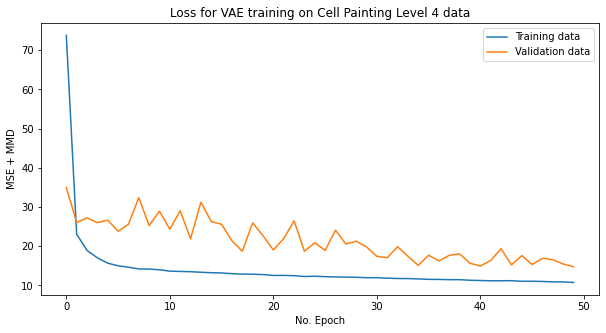

In [168]:
plt.figure(figsize=(10, 5))
plt.plot(history_df["loss"], label="Training data")
plt.plot(history_df["val_loss"], label="Validation data")
plt.title("Loss for VAE training on Cell Painting Level 4 data")
plt.ylabel("MSE + MMD")
plt.xlabel("No. Epoch")
plt.legend()
plt.show()

In [152]:
cp_vae.vae.evaluate(test_features_df)

158/158 [==============================] - 0s 2ms/step - loss: 14.6742 - recon: 0.5176 - kl: 0.0000e+00 - mmd: 14.8060


[14.674155235290527, 0.5175955295562744, 0.0, 14.806024551391602]

In [153]:
reconstruction = pd.DataFrame(cp_vae.vae.predict(test_features_df), columns=cp_features)
(sum(sum((np.array(test_features_df) - np.array(reconstruction)) ** 2))) ** 0.5

50.86039485993831

<AxesSubplot:>

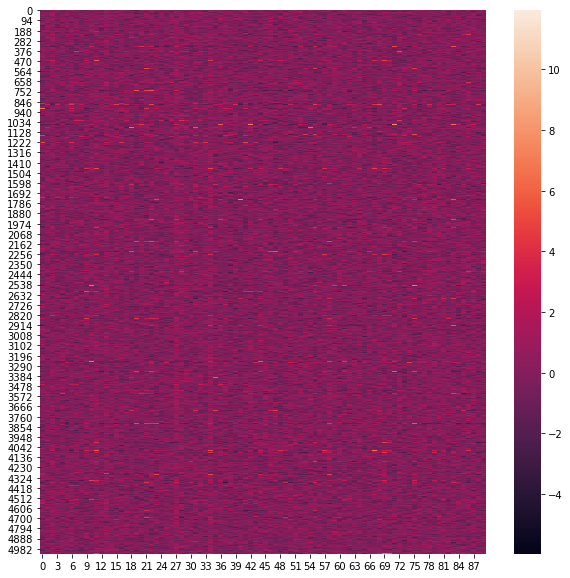

In [164]:
#latent space heatmap
fig, ax = plt.subplots(figsize=(10, 10))
encoder = cp_vae.encoder_block["encoder"]
latent = np.array(encoder.predict(test_features_df)[2])
seaborn.heatmap(latent, ax=ax)

In [165]:
#original vs reconstructed heatmap
#use these 3 lines if you need to regenerate it
# encoder = keras.models.load_model("level4Encoder")
# decoder = keras.models.load_model("level4Decoder")
# reconstruction = pd.DataFrame(decoder.predict(encoder.predict(test_features_df)[2]), columns=cp_features)

reconstruction = pd.DataFrame(cp_vae.vae.predict(test_features_df), columns=cp_features)
pca = PCA(n_components=2).fit(test_features_df)
pca_reconstructed_latent_df = pd.DataFrame(pca.transform(reconstruction))
pca_test_latent_df = pd.DataFrame(pca.transform(test_features_df))
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
# seaborn.heatmap(test_features_df, ax=ax1)
# seaborn.heatmap(reconstruction, ax=ax2)
# plt.show()

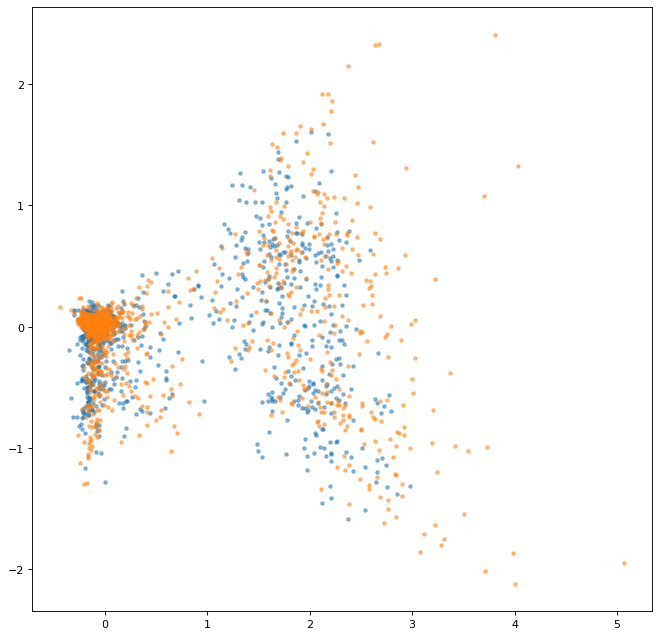

In [156]:
figure(figsize=(10, 10), dpi=80)
plt.scatter(pca_test_latent_df[0],pca_test_latent_df[1], marker = ".", alpha = 0.5)
plt.scatter(pca_reconstructed_latent_df[0],pca_reconstructed_latent_df[1], marker = ".", alpha = 0.5)

In [157]:
# decoder = keras.models.load_model("level4Decoder2")
# encoder = keras.models.load_model("level4Encoder2")

In [50]:
# reconstruction = decoder.predict(encoder.predict(test_features_df)[2])

In [166]:
import umap
reducer = umap.UMAP().fit(test_features_df)
original_test_embedding = reducer.transform(test_features_df)
reconstructed_test_embedding = reducer.transform(reconstruction)

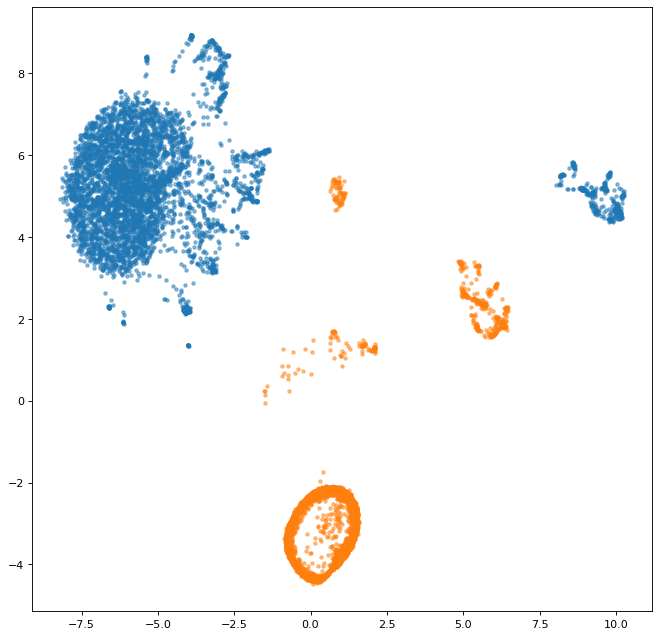

In [167]:
figure(figsize=(10, 10), dpi=80)
plt.scatter(original_test_embedding[:,0],original_test_embedding[:,1], marker = ".", alpha = 0.5)
plt.scatter(reconstructed_test_embedding[:,0],reconstructed_test_embedding[:,1], marker = ".", alpha = 0.5)

In [53]:
# #difference between original and reconstructed heatmap
# difference = abs(reconstruction - test_features_df)
# fig, ax = plt.subplots(figsize=(10, 10))
# seaborn.heatmap(difference, ax=ax, cmap="Blues")

In [54]:
# #encoder heatmap
# weights = cp_vae.encoder_block["encoder"].get_weights()
# fig, ax = plt.subplots(figsize=(10, 10))
# seaborn.heatmap(weights[0], ax=ax)

In [55]:
# latent_dims = np.arange(1,51)
# reconstructions = []

# for latent_dim in latent_dims:
#     cp_vae2 = VAE(
#         input_dim=train_features_df.shape[1],
#         latent_dim=latent_dim,
#         batch_size=32,
#         encoder_batch_norm=True,
#         epochs=14,
#         learning_rate=0.01,
#         encoder_architecture=encoder_architecture,
#         decoder_architecture=decoder_architecture,
#         beta=1,
#         verbose=True,
#     )
#     cp_vae2.compile_vae()
#     cp_vae2.train(x_train=train_features_df, x_test=test_features_df)
#     reconstruction = pd.DataFrame(cp_vae2.vae.predict(test_features_df), columns=cp_features)
#     reconstructions.append(reconstruction)


In [56]:
# frobenius_norms = []
# for reconstruction in reconstructions:
#     frobenius_norms.append(
#         (sum(sum((np.array(test_features_df) - np.array(reconstruction)) ** 2))) ** 0.5
#     )

In [57]:
# plt.plot(frobenius_norms)
# plt.xlabel("latent_dim")
# plt.ylabel("Frobenius Norm")
# plt.title("Cell Painting VAE")
# plt.show()

In [158]:
decoder = cp_vae.decoder_block["decoder"]

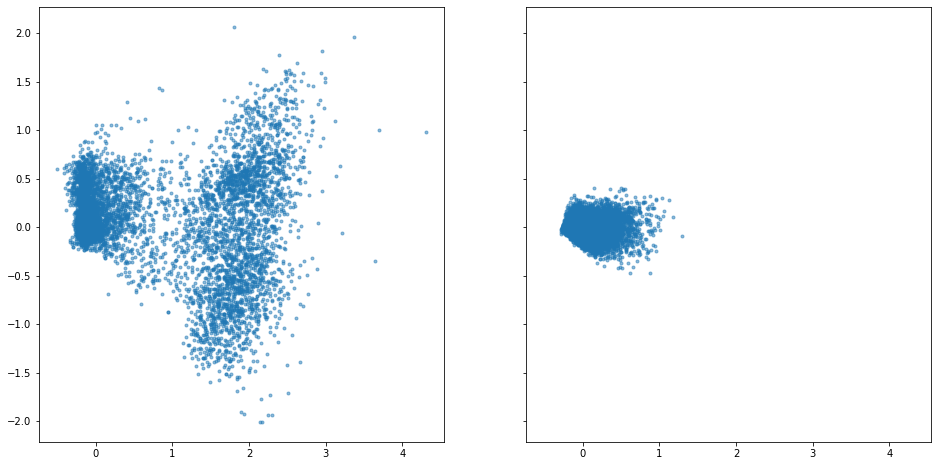

In [159]:
pca_training = PCA(n_components=2).fit(train_features_df)

simulated_df = pd.DataFrame(np.random.normal(size=(40242, 90)), columns=np.arange(0,90))
reconstruction_of_simulated = decoder.predict(simulated_df)
pca_reconstruction_of_simulated = pd.DataFrame(pca_training.transform(reconstruction_of_simulated))
pca_train_latent_df = pd.DataFrame(pca_training.transform(train_features_df))

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16,8), sharey = True, sharex = True)
ax1.scatter(pca_train_latent_df[0],pca_train_latent_df[1], marker = ".", alpha = 0.5)
ax2.scatter(pca_reconstruction_of_simulated[0],pca_reconstruction_of_simulated[1], marker = ".", alpha = 0.5)

In [160]:
from scipy.spatial.distance import directed_hausdorff
max(directed_hausdorff(reconstruction_of_simulated, train_features_df)[0],directed_hausdorff(train_features_df,reconstruction_of_simulated)[0])

8.920078567927153

In [172]:
simulated_test_df = pd.DataFrame(np.random.normal(size=(5030, 90)), columns=np.arange(0,90))
reconstruction_of_simulated_test = decoder.predict(simulated_test_df)

In [173]:
simulated_embedding = reducer.transform(reconstruction_of_simulated_test)

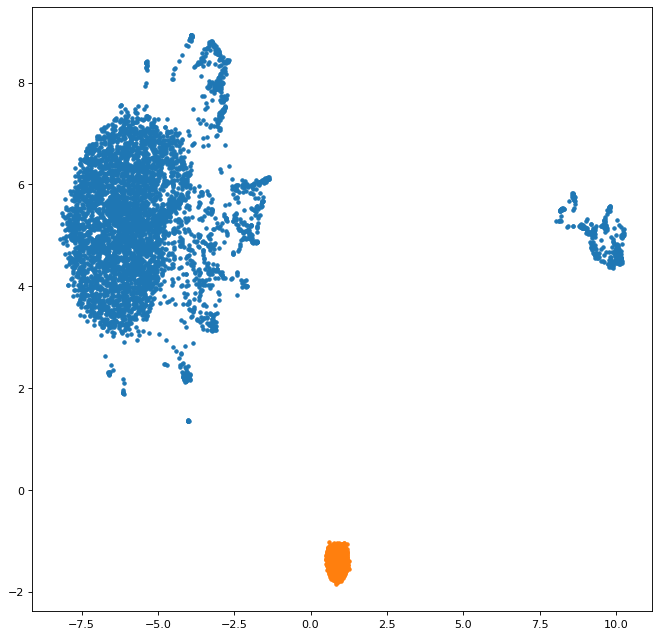

In [174]:
figure(figsize=(10, 10), dpi=80)
plt.scatter(
    original_test_embedding[:, 0],
    original_test_embedding[:, 1],
#     c=[sns.color_palette()[x] for x in penguins.species_short.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})]
    marker = '.'
)
plt.scatter(
    simulated_embedding[:, 0],
    simulated_embedding[:, 1],
#     c=[sns.color_palette()[x] for x in penguins.species_short.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})]
    marker = '.'
)
# plt.gca().set_aspect('equal', 'datalim')
# plt.title('UMAP projection of the cell painting level 5 test set')

In [161]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
latent_complete = np.array(encoder.predict(complete_features_df)[2])
latent_df = pd.DataFrame(latent_complete)
latent_df.to_csv("../3.application/level4Latent_mmd.csv")

In [162]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
decoder.save("level4Decoder_mmd")

INFO:tensorflow:Assets written to: level4Decoder_mmd/assets


In [163]:
encoder.save("level4Encoder_mmd")

INFO:tensorflow:Assets written to: level4Encoder_mmd/assets
